In [166]:
%matplotlib inline
from pathlib import Path
import pickle
from PIL import Image
import io
import gdown
import zipfile

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import argparse

manualSeed = 999

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [167]:
url = 'https://drive.google.com/uc?id=1A423Vi62SWb3FHtwieXDlmtIEcQHb2ub'
outfile = "imgs.zip"

if not os.path.exists("imgs"):
    gdown.download(url, outfile, quiet=False)

    with zipfile.ZipFile(outfile, 'r') as zip_ref:
        zip_ref.extractall()
    os.remove("imgs.zip")

In [168]:
# Root directory for dataset
cwd = os.getcwd() # collect current working directory
dataroot = Path(f"{cwd}/imgs") # define data directory

# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100
# num_epochs = 400

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

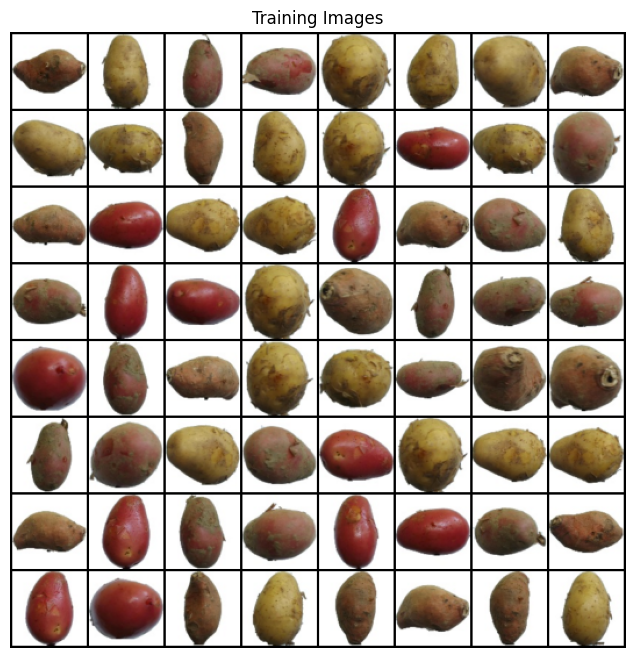

In [169]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [170]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [171]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.trainImgs = []
        self.losses = []
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [172]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, [0])

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [173]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.losses = []
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [174]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, [0])

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.2, inplace=False)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Dropout2d(p=0.2, inplace=False)
    (13): Conv2d(512, 1, kernel_size=(4, 4),

In [175]:
class Results():
    def __init__(self):
        self.trainImgs = []
        self.gLosses = []
        self.dLosses = []

In [176]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
def smoth_label():
    return 1.-0.3+random.random()*0.5


real_label = smoth_label() #0.7~1.2
fake_label = random.random()*0.3

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [177]:
def trainGAN():
    # Training Loop
    random.seed(123)

    # result object to keep track of progress
    results = Results()
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader,0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item() 
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            results.gLosses.append(errG.item())
            results.dLosses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                results.trainImgs.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
    # return img_list, G_losses, D_losses
    return results

In [178]:
model_dir = Path('models')
g_path = os.path.join(model_dir,'potato_g.pkl')
d_path = os.path.join(model_dir,'potato_d.pkl')
r_path = os.path.join(model_dir,'results.pkl')

if not os.path.exists(g_path) or not os.path.exists(d_path):
    results = trainGAN()

In [179]:
# save pickle file for both models and result objects, if file does not exist
if not os.path.exists(g_path):
    g_file = open(g_path, 'wb')
    pickle.dump(netG, g_file)
    g_file.close()

if not os.path.exists(d_path):
    g_file = open(d_path, 'wb')
    pickle.dump(netG, g_file)
    g_file.close()

if not os.path.exists(r_path):
    r_file = open(r_path, 'wb')
    pickle.dump(results, r_file)
    r_file.close()

# delete pickle files and re-run notebook to save new model and result objects

In [180]:
# define class to unpickle on current device (CPU or GPU), independent of which device the model was trained on.
class DeviceUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

In [181]:
# load pickle file for each model
g_file = open(g_path, 'rb')
newNetG = DeviceUnpickler(g_file).load()
g_file.close()

d_file = open(d_path, 'rb')
newNetD = DeviceUnpickler(d_file).load()
d_file.close()

r_file = open(r_path, 'rb')
newResults = pickle.Unpickler(r_file).load()
r_file.close()

# send both models to CPU if no GPU is available
if not torch.cuda.is_available():
    newNetG = newNetG.module.to(device)
    newNetD = newNetD.module.to(device)

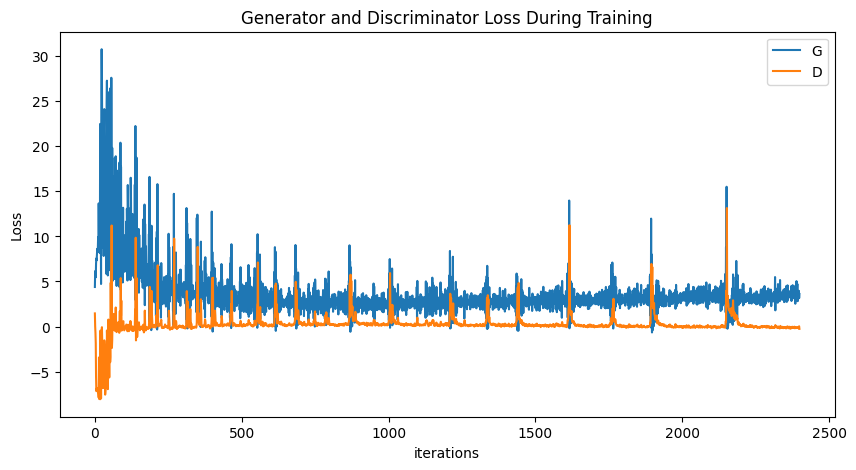

In [182]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(newResults.gLosses,label="G")
plt.plot(newResults.dLosses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

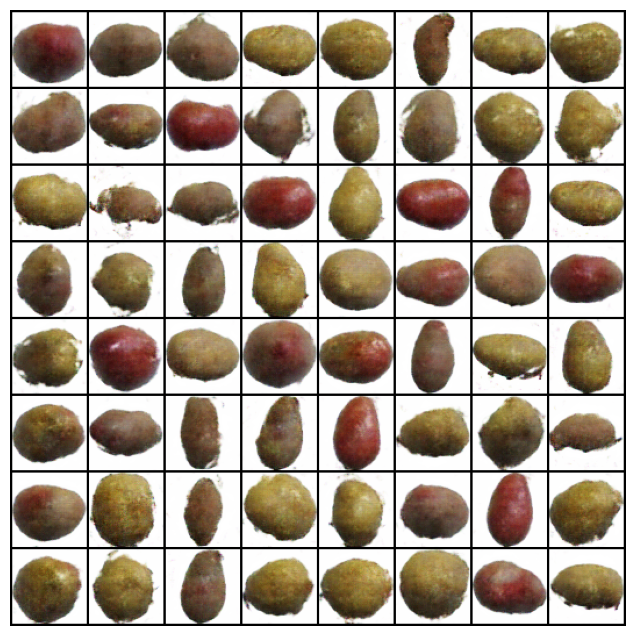

In [183]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in newResults.trainImgs[0:10]]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [184]:
def random_tater(model):
    noise = torch.randn(64, 100, 1, 1, device=device)
    fakes = model(noise).detach().cpu()
    fake_img = fakes[0]
    grid = vutils.make_grid(fake_img, padding=2, normalize=True)
    return transforms.ToPILImage()(grid)

In [185]:
tater = random_tater(newNetG)
tater.show()